In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import datetime as dt
import contractions

import spacy
from spacy.lang.en import English
import en_core_web_sm

from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from gensim import corpora, models, similarities, matutils

import pyLDAvis
import pyLDAvis.sklearn

from nltk.corpus import words

from os import listdir
from os.path import isfile, join

pd.set_option('display.max_colwidth', None)

# Importing Data

In [125]:
filepath = './data'

In [129]:
filenames = [f for f in listdir(filepath) if isfile(join(filepath, f))]

In [130]:
df_list = [pd.read_csv(filepath + '/' + filename, index_col=0) for filename in filenames]
df = pd.concat(df_list, axis=0, ignore_index=True)

In [3]:
# df = pd.read_csv('cleaned_submissions_for_analysis.csv', index_col=0)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        22500 non-null  object 
 1   url       22500 non-null  object 
 2   title     22500 non-null  object 
 3   selftext  22500 non-null  object 
 4   created   22500 non-null  float64
dtypes: float64(1), object(4)
memory usage: 879.0+ KB


In [133]:
df.sort_values(by='created', ascending=True, inplace=True)

In [134]:
df['selftext'].sample()

17481    So twitter just banned Trump from tweeting after posting a clip from Fox News saying kids were “almost immune” from the ‘roni. \n\nWas anyone lucky enough to buy a put today?\n\n\nhttps://twitter.com/dhookstead/status/1291170611356631040?s=21
Name: selftext, dtype: object

In [135]:
df['documents'] = df['title'] + ' ' + df['selftext']

In [136]:
df['documents']

17173                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [137]:
df['date'] = pd.to_datetime(df['created'], unit='s')

In [138]:
df[['documents', 'date']].head()

documents  \
17173                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Study of market breadth for

In [139]:
df['date'].describe()

/var/folders/9d/md8fr0yx4llgp_hpgf4vrj180000gn/T/ipykernel_9350/801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                   22500
unique                  22318
top       2021-02-03 05:32:58
freq                        7
first     2019-01-02 00:49:31
last      2021-11-08 15:38:46
Name: date, dtype: object

In [140]:
df['documents'].sample()

16124    Shower thought: Roaring kitty He went, which is ok, everyone should be able to leave when they want and are entitled to their own opinions. As. This is a free market (sarcasm)\n\nBut think why. Well he was important. He was a figure head, a face the people put on this, all big movements have a figurehead (history 101). hedges know this and (conspiracy alert; maybe pressured him to withdraw from socials/reddit. )\n\nI am not smart. I am self taught, am 21 and have been holding since March. Maybe a 🦍 could progress this thought.
Name: documents, dtype: object

In [141]:
df['id'].value_counts()

abjlp1    1
nredzx    1
nrel5i    1
nreix5    1
nreinu    1
         ..
laoc0e    1
laob5k    1
laoaru    1
lao9zo    1
qp8o9a    1
Name: id, Length: 22500, dtype: int64

# Text Preprocessing

In [153]:
#contractions
contr = lambda x: contractions.fix(x)

#remove newline (\n)
newline = lambda x: x.replace("\\n", " ")

nbsp = lambda x: x.replace('&nbsp', "")
ampersands = lambda x: x.replace("&amp", "")
greater_than = lambda x: x.replace("&gt", "")
less_than = lambda x: x.replace("&lt", "")
x200b = lambda x: x.replace("&#x200B;", "")

#remove links
links = lambda x: re.sub(r"https?://\S+", " ", x)

#remove punctuation
punctuation = lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

#lowercase
lowercase = lambda x: x.lower()

#remove digits
digits = lambda x: re.sub(r"\b[0-9]+\b\s*", "", x)

#remove extra spaces
spaces = lambda x: " ".join(x.split())

#stock symbols: gme, amc, tsla, clov, pltr - replace if unusual combination of letters and company name is one word
tsla = lambda x: x.replace("tsla", "tesla")
pltr = lambda x: x.replace("pltr", "palantir")
tlry = lambda x: x.replace("tlry", "tilray")
gme = lambda x: x.replace("gme", "gamestop")

In [154]:
df['docs_clean'] = df['documents'].map(contr).map(nbsp).map(newline).map(links).map(ampersands).map(greater_than).map(less_than).map(x200b).map(punctuation).map(lowercase).map(digits).map(spaces).map(tsla).map(pltr).map(tlry).map(gme)

In [143]:
df[['documents', 'docs_clean']]

documents  \
17173                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [17]:
date_ranges = [[date.date(), date.date() + dt.timedelta(days=7)] for date in pd.date_range('2019-01-01', periods=35, freq="MS")]

In [144]:
n = np.random.choice(range(len(date_ranges)))
df_selected_range = df[(df['created'] > float(date_ranges[n][0].strftime('%s'))) & (df['created'] < float(date_ranges[n][1].strftime('%s')))].copy()

In [145]:
df_selected_range['date'].head()

10664   2019-11-01 15:37:13
10663   2019-11-01 19:29:31
10662   2019-11-01 20:43:32
10661   2019-11-01 21:49:16
10660   2019-11-01 22:19:14
Name: date, dtype: datetime64[ns]

In [146]:
submission_counts_by_month = [len(df[(df['created'] > float(date_ranges[n][0].strftime('%s'))) & (df['created'] < float(date_ranges[n][1].strftime('%s')))])\
                                  for n in range(len(date_ranges))]

In [147]:
submission_counts_by_month

[69,
 56,
 54,
 46,
 75,
 95,
 49,
 121,
 102,
 76,
 168,
 135,
 118,
 340,
 690,
 430,
 507,
 211,
 300,
 620,
 593,
 332,
 201,
 925,
 528,
 2979,
 1031,
 1039,
 1406,
 2871,
 1299,
 1185,
 1088,
 668,
 1288]

In [148]:
import matplotlib.pyplot as plt

In [149]:
[date_range[0] for date_range in date_ranges]

[datetime.date(2019, 1, 1),
 datetime.date(2019, 2, 1),
 datetime.date(2019, 3, 1),
 datetime.date(2019, 4, 1),
 datetime.date(2019, 5, 1),
 datetime.date(2019, 6, 1),
 datetime.date(2019, 7, 1),
 datetime.date(2019, 8, 1),
 datetime.date(2019, 9, 1),
 datetime.date(2019, 10, 1),
 datetime.date(2019, 11, 1),
 datetime.date(2019, 12, 1),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 4, 1),
 datetime.date(2020, 5, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 7, 1),
 datetime.date(2020, 8, 1),
 datetime.date(2020, 9, 1),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 11, 1),
 datetime.date(2020, 12, 1),
 datetime.date(2021, 1, 1),
 datetime.date(2021, 2, 1),
 datetime.date(2021, 3, 1),
 datetime.date(2021, 4, 1),
 datetime.date(2021, 5, 1),
 datetime.date(2021, 6, 1),
 datetime.date(2021, 7, 1),
 datetime.date(2021, 8, 1),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 11, 1)]

In [72]:
date_ranges[0][0].strftime('%b %Y')

'Jan 2019'

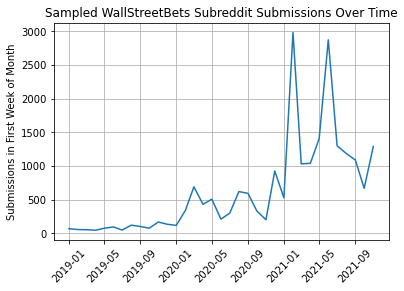

In [160]:
plt.title('Sampled WallStreetBets Subreddit Submissions Over Time')
plt.ylabel('Submissions in First Week of Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.plot([date_range[0] for date_range in date_ranges], submission_counts_by_month)
plt.savefig('submissions_time_series.png', facecolor='w', edgecolor='w', dpi=200, bbox_inches='tight');

In [182]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [200]:
def get_top_keywords_over_time(date_ranges, no_top_words):
    output_list = []
    for n in range(len(date_ranges)):
        sub_df = df[(df['created'] > float(date_ranges[n][0].strftime('%s'))) & (df['created'] < float(date_ranges[n][1].strftime('%s')))].copy()
        max_features = len(sub_df['docs_clean']) // 4 * 3
        vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, min_df=0.0, max_df=0.9)
        doc_word = vectorizer.fit_transform(sub_df['docs_clean'])
        nmf_model = NMF(5)
        doc_topic = nmf_model.fit_transform(doc_word)
        top_words = [vectorizer.get_feature_names_out()[j] for j in nmf_model.components_[0].argsort()[:-no_top_words-1:-1]]
        output_list.append([date_ranges[n][0], top_words])
    return output_list

In [204]:
pd.DataFrame(get_top_keywords_over_time(date_ranges, 5))

,0,1
0,2019-01-01,"[china, apple, markets, sales, guidance]"
1,2019-02-01,"[snap, app, public, bad, puts]"
2,2019-03-01,"[deal, beat, help, investing, china]"
3,2019-04-01,"[puts, tomorrow, growth, daily, target]"
4,2019-05-01,"[tomorrow, try, morning, mid, playing]"
5,2019-06-01,"[puts, spy, risk, having, funds]"
6,2019-07-01,"[rate, cut, margin, bad, higher]"
7,2019-08-01,"[puts, yolo, playing, worth, selling]"
8,2019-09-01,"[puts, spy, volume, work, news]"
9,2019-10-01,"[expected, tgt, yr, initiated, guidance]"


In [ ]:
#create database and add all data for use by app

In [21]:
from sqlalchemy import create_engine, MetaData, Table, Column, String, Date

In [151]:
engine = create_engine('sqlite:///data.db')

In [24]:
meta = MetaData()

submissions = Table(
    'submissions', meta,
    Column('date', Date),
    Column('docs_clean', String)
    )
meta.create_all(engine)

In [155]:
df[['date', 'docs_clean']].to_sql('submissions', con=engine, if_exists='replace', index=False)

## Word Cloud

In [28]:
from wordcloud import WordCloud

In [38]:
def display_wordcloud(text):
    wc_text = ' '.join(text)
    wordcloud = WordCloud(stopwords = stop_words.union('s'), random_state=137, background_color='white',
                      collocations=True).generate(wc_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

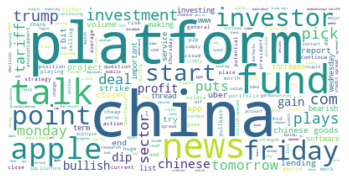

In [40]:
display_wordcloud(df_selected_range['docs_clean'])

# Vectorization

In [29]:
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [205]:
my_stop_words = ['like', 'likes', 'just', 'shares', 'guys', 'click', 'x200b', 'going', 'went', 'stock', 'stocks', 'market', 'know', 'link', 'think',\
                'want', 'ape', 'apes', 'company', 'companies', 'earnings', 'short', 'shit', 'fucking', 'million', 'billion', 'revenue', 'let', 'got',\
                 'fuck', 'fucking', 'fucked', 'retard', 'retards', 'retarded', 'people', 'mods', 'sub', 'post', 'did', 'ass', 'make', 'maybe',\
                 'tell', 'getting', 'autist', 'autists', 'autistic', 'tendies', 'listen', 'remember', 'talking', 'buy', 'hold', 'sell', 'good', 'new', 'time', 'today',\
                'week', 'use', 'invest', 'bought', 'need', 'day', 'really', 'right', 'high', 'low', 'big', 'need', 'right', 'money', 'cash',\
                'lot', 'need', 'does', 'day', 'right', 'way', 'price', 'trade', 'trading', 'trades', 'calls', 'option', 'options', 'short',\
                 'shorts', 'shorted', 'long', 'share', 'thoughts', 'missed', 'come', 'coming', 'doing', 'thing', 'trying', 'say', 'feel', 'goes', 'actually', 'porn',\
                 'meme', 'squeeze', 'holding', 'buying', 'wsb', 'days', 'lose', 'look', 'looking', 'knows', 'believe', 'possibly', 'said', 'nbsp',\
                'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'thinking',\
                'month', 'year', 'years', 'probably', 'better', 'tl', 'dr', 'likely', 'sure', 'great', 'months', 'things', 'means', 'started', 'business',\
                 'industry', 'based', 'pretty', 'total', 'best', 'real', 'currently', 'play', 'kind', 'little', 'yeah', 'nbsp', 'hello', 'hey', 'dd', 'tldr']
stop_words = ENGLISH_STOP_WORDS.union(my_stop_words)

In [206]:
len(my_stop_words)

162

## Count Vectorization

In [243]:
cv = CountVectorizer(stop_words=stop_words, min_df=0.05, max_df=0.8, max_features=1000)
df_fit = cv.fit_transform(df_selected_range['docs_clean'])
cv_df = pd.DataFrame(df_fit.toarray(), columns=cv.get_feature_names_out())

In [244]:
df_fit

<2871x94 sparse matrix of type '<class 'numpy.int64'>'
	with 20919 stored elements in Compressed Sparse Row format>

In [245]:
cv_df

,actually,advice,ago,amc,based,bb,believe,best,better,business,...,trying,using,value,volume,work,world,worth,wsb,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,20,0,0,0,0,0,0,...,0,2,2,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,1,0,0,0,0,0
2867,0,0,0,4,0,1,0,0,0,0,...,0,0,0,1,2,0,0,0,0,0
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,1,0,0,1,0,1,0,2,0,...,0,0,8,4,0,0,0,2,0,0


In [246]:
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(cv_df)
lsa.explained_variance_ratio_

array([0.17674869, 0.09715192, 0.07670252, 0.0412617 , 0.02742437])

In [247]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1", "component_2", "component_3", "component_4", "component_5"],
             columns = cv.get_feature_names_out())
topic_word

,actually,advice,ago,amc,based,bb,believe,best,better,business,...,trying,using,value,volume,work,world,worth,wsb,year,years
component_1,0.051,0.039,0.030,0.768,0.042,0.299,0.051,0.042,0.047,0.054,...,0.040,0.029,0.074,0.089,0.026,0.024,0.031,0.035,0.091,0.069
component_2,0.052,0.061,0.017,-0.550,0.090,0.183,0.075,0.070,0.075,0.121,...,0.027,0.056,0.176,0.110,0.050,0.065,0.053,0.041,0.262,0.163
component_3,-0.003,-0.005,-0.018,-0.149,-0.048,0.903,-0.042,-0.008,-0.038,-0.059,...,-0.018,-0.013,-0.083,-0.039,-0.022,-0.007,-0.013,0.004,-0.110,-0.051
component_4,0.018,0.010,0.014,0.157,0.015,0.028,0.004,0.084,0.052,0.154,...,0.005,0.063,0.172,-0.128,-0.006,0.049,0.048,-0.022,0.174,0.167
component_5,0.026,0.020,0.015,-0.119,0.092,-0.139,-0.013,0.025,-0.023,0.031,...,0.033,0.015,0.005,-0.069,0.030,0.021,0.003,0.057,0.064,-0.017


In [47]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_, 1):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [248]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  1
amc, bb, gme, squeeze, retail

Topic  2
year, growth, bb, dd, value

Topic  3
bb, meme, gme, dd, moon

Topic  4
retail, year, value, years, amc

Topic  5
gme, dd, days, based, selling


## TF-IDF

In [55]:
df_selected_range.shape

(1288, 8)

In [56]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=0.05, max_df=0.8, max_features=1000)
df_fit = tfidf.fit_transform(df_selected_range['docs_clean'])
tfidf_df = pd.DataFrame(df_fit.toarray(), columns=tfidf.get_feature_names_out())

In [57]:
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(tfidf_df)
lsa.explained_variance_ratio_

array([0.01592259, 0.03261605, 0.03154138, 0.0261167 , 0.02175505])

In [58]:
tfidf_df.shape

(1288, 96)

In [59]:
display_topics(lsa, tfidf.get_feature_names_out(), 7)


Topic  1
tesla, gme, help, news, growth, potential, dd

Topic  2
help, advice, thanks, account, start, investment, gme

Topic  3
tesla, tsla, help, selling, worth, thanks, start

Topic  4
gme, open, selling, thanks, seen, start, makes

Topic  5
advice, investing, start, tsla, gains, account, puts


In [87]:
def create_lsa_tfidf(docs, num_topics, stop_words, min_df, max_df, max_features):
    tfidf = TfidfVectorizer(stop_words=stop_words, min_df=min_df, max_df=max_df, max_features=max_features)
    df_fit = tfidf.fit_transform(docs)
    tfidf_df = pd.DataFrame(df_fit.toarray(), columns=tfidf.get_feature_names_out())
    lsa = TruncatedSVD(num_topics)
    doc_topic = lsa.fit_transform(tfidf_df)
    return lsa, tfidf

In [88]:
lsa, tfidf = create_lsa_tfidf(df_selected_range['docs_clean'], 5, stop_words, 0.05, 0.90, 1000)

In [89]:
for n in range(1, 11):
    lsa = TruncatedSVD(n)
    doc_topic = lsa.fit_transform(tfidf_df)
    print(f'---begin {n} topic(s)---')
    display_topics(lsa, tfidf.get_feature_names_out(), 7)
    print(f'---end {n} topic(s)---\n')

---begin 1 topic(s)---

Topic  1
tesla, gme, help, news, growth, potential, dd
---end 1 topic(s)---

---begin 2 topic(s)---

Topic  1
tesla, gme, help, news, growth, potential, dd

Topic  2
help, advice, thanks, account, start, gme, investment
---end 2 topic(s)---

---begin 3 topic(s)---

Topic  1
tesla, gme, help, news, growth, potential, dd

Topic  2
help, advice, thanks, account, start, investment, gme

Topic  3
tesla, tsla, help, selling, worth, thanks, start
---end 3 topic(s)---

---begin 4 topic(s)---

Topic  1
tesla, gme, help, news, growth, potential, dd

Topic  2
help, advice, thanks, account, start, investment, gme

Topic  3
tesla, tsla, help, selling, worth, thanks, run

Topic  4
gme, open, selling, thanks, volume, seen, makes
---end 4 topic(s)---

---begin 5 topic(s)---

Topic  1
tesla, gme, help, news, growth, potential, dd

Topic  2
help, advice, account, thanks, start, investment, gme

Topic  3
tesla, tsla, help, selling, worth, thanks, start

Topic  4
gme, open, thanks,

# LDA

In [105]:
count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=1000, min_df=0.05, max_df=0.7)
count_vectorizer.fit(df_selected_range['docs_clean'])
doc_word = count_vectorizer.transform(df_selected_range['docs_clean']).transpose()

In [97]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), max_features=1000, max_df=0.7)
tfidf_vectorizer.fit(df_selected_range['docs_clean'])
doc_word = tfidf_vectorizer.transform(df_selected_range['docs_clean']).transpose()

In [ ]:
pd.DataFrame(doc_word.toarray(), tfidf_vectorizer.get_feature_names_out()).head()

In [107]:
doc_word.shape

(96, 1288)

In [108]:
corpus = matutils.Sparse2Corpus(doc_word)

In [109]:
id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

In [110]:
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

In [111]:
lda.print_topics()

[(0,
  '0.076*"basis" + 0.045*"ai" + 0.043*"afternoon" + 0.031*"america" + 0.030*"app" + 0.030*"assets" + 0.029*"banking" + 0.028*"bad" + 0.022*"acquisitions" + 0.021*"120b"'),
 (1,
  '0.071*"ago" + 0.042*"beating" + 0.032*"beat" + 0.028*"additional" + 0.027*"allow" + 0.025*"acquisitions" + 0.024*"archegos" + 0.024*"amd" + 0.024*"basically" + 0.023*"attention"'),
 (2,
  '0.049*"action" + 0.029*"beginning" + 0.028*"approval" + 0.028*"active" + 0.027*"apha" + 0.024*"autodesk" + 0.021*"28th" + 0.021*"bb" + 0.021*"area" + 0.019*"ability"'),
 (3,
  '0.069*"additionally" + 0.036*"annual" + 0.036*"benefit" + 0.035*"adjusted" + 0.026*"ask" + 0.026*"bbig" + 0.026*"article" + 0.025*"atm" + 0.025*"apple" + 0.023*"analysis"'),
 (4,
  '0.043*"amy" + 0.037*"assuming" + 0.036*"analysis" + 0.033*"advice" + 0.025*"article" + 0.024*"amd" + 0.023*"american" + 0.023*"assume" + 0.023*"action" + 0.022*"10b"')]

In [501]:
lda_corpus = lda[corpus]
lda_corpus

In [502]:
lda_docs = [doc for doc in lda_corpus]

In [503]:
lda_docs[0:20]

[[(0, 0.062413417),
  (1, 0.75205326),
  (2, 0.062180586),
  (3, 0.06108792),
  (4, 0.062264863)],
 [(0, 0.058896124),
  (1, 0.058585458),
  (2, 0.49601623),
  (3, 0.32516855),
  (4, 0.06133366)],
 [(0, 0.06355616),
  (1, 0.7439573),
  (2, 0.066872),
  (3, 0.06298896),
  (4, 0.06262561)],
 [(0, 0.062302068),
  (1, 0.35357505),
  (2, 0.260033),
  (3, 0.26167798),
  (4, 0.06241188)],
 [(0, 0.030389454),
  (1, 0.88198346),
  (2, 0.029046837),
  (3, 0.029571874),
  (4, 0.029008327)],
 [(0, 0.02102781),
  (1, 0.91558075),
  (2, 0.021142315),
  (3, 0.02103896),
  (4, 0.02121013)],
 [(0, 0.030882552),
  (1, 0.8750837),
  (2, 0.03143807),
  (3, 0.030637229),
  (4, 0.031958416)],
 [(0, 0.26685235),
  (1, 0.6516266),
  (2, 0.02740827),
  (3, 0.027066266),
  (4, 0.027046507)],
 [(0, 0.10044039),
  (1, 0.104111336),
  (2, 0.10000679),
  (3, 0.10000734),
  (4, 0.5954342)],
 [(0, 0.10004962),
  (1, 0.10000035),
  (2, 0.1000004),
  (3, 0.5999493),
  (4, 0.10000039)],
 [(0, 0.03921556),
  (1, 0.302143

In [504]:
df.docs_clean[12]

'is anyone else doing this just because they want to be free just like the title i just want to be financially free i live well within my means people even call me a penny pincher cheapskate ect my goal is 30k so i can day trade and quit my day job and babysit my child my wife wants to continue traditional work so it works out in my head'

## pyLDAvis

In [41]:
tf_vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.9, max_features=1000)
dtm_tf = tf_vectorizer.fit_transform(df_selected_range['docs_clean'])

In [42]:
lda_tf = LatentDirichletAllocation(n_components=5, random_state=137)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(n_components=5, random_state=137)

In [43]:
pyLDAvis.enable_notebook()

In [44]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.122730 -0.096857       1        1  39.992514
4     -0.203446 -0.028323       2        1  24.984751
3      0.036690  0.196885       3        1  14.407051
1      0.052243 -0.027918       4        1  13.699768
2     -0.008217 -0.043788       5        1   6.915916, topic_info=         Term       Freq      Total Category  logprob  loglift
599  platform  23.000000  23.000000  Default  30.0000  30.0000
918     trump  27.000000  27.000000  Default  29.0000  29.0000
51      apple  16.000000  16.000000  Default  28.0000  28.0000
877   tariffs  14.000000  14.000000  Default  27.0000  27.0000
348     goods  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
943     value   1.233033   4.336108   Topic5  -5.3336   1.4138
67    average   1.232912   7.862028   Topic5  -5.3337   0.8187
451     learn   1.232859   5.272592   Topic5  -5.3338   1.2182
473      lost   1.232526   6.041790   Topic5  -5.3341   1.0817
259       etf   1.232508   6.268718   Topic5  -5.3341   1.0448

[266 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
15        1  0.922288          action
18        3  0.913076        addition
19        3  0.913076      additional
23        3  0.683779  administration
24        1  0.937455       advantage
...     ...       ...             ...
973       4  0.110145       wednesday
978       4  0.388601            wifi
978       5  0.388601            wifi
991       2  0.890602             www
999       2  0.742990             錢盆網

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

In [368]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), max_df=0.8)
dtm_tfidf = tfidf_vectorizer.fit_transform(df['docs_clean'])

In [369]:
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=137)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=5, random_state=137)

In [366]:
pyLDAvis.enable_notebook()

In [370]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.004691  0.002220       1        1  25.652426
2      0.003621  0.003492       2        1  21.324840
3      0.000618 -0.002348       3        1  19.578347
0      0.000243 -0.002162       4        1  17.080843
1      0.000209 -0.001203       5        1  16.363544, topic_info=              Term      Freq     Total Category  logprob  loglift
118698  matterport  0.000000  0.000000  Default  30.0000  30.0000
28668     cannabis  0.000000  0.000000  Default  29.0000  29.0000
1813           40b  0.000000  0.000000  Default  28.0000  28.0000
310           120b  0.000000  0.000000  Default  27.0000  27.0000
78301       fy2022  0.000000  0.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
82126         good  0.126601  0.998366   Topic5 -10.1296  -0.2550
165552     revenue  0.115656  0.732849   Topic5 -10.2200  -0.0362
187176      stocks  0.122219  1.143960   Topic5 -10.1648  -0.4263
212640        want  0.113744  0.795874   Topic5 -10.2367  -0.1354
198639        time  0.109330  0.981023   Topic5 -10.2763  -0.3841

[376 rows x 6 columns], token_table=        Topic     Freq   Term
term                         
177456      1  0.70073  short, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

# NMF

In [112]:
cv = CountVectorizer(stop_words=stop_words, max_features=5000, min_df=0.05, max_df=0.9)
doc_word = cv.fit_transform(df_selected_range['docs_clean'])
cv_df = pd.DataFrame(doc_word.toarray(), columns=cv.get_feature_names_out())

In [520]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [521]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5"],
             columns = cv.get_feature_names())
topic_word

/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,dd,open,puts,term
component_1,0.000,0.149,0.000,0.000
component_2,0.000,0.000,0.539,0.000
component_3,0.000,0.000,0.000,0.761
component_4,0.550,0.000,0.000,0.000
component_5,0.249,0.000,0.000,0.000


In [522]:
display_topics(nmf_model, cv.get_feature_names_out(), 10)


Topic  1
open, puts, term, dd

Topic  2
puts, term, open, dd

Topic  3
term, puts, dd, open

Topic  4
dd, puts, term, open

Topic  5
dd, term, puts, open


In [123]:
def create_nmf_model(docs, num_topics, num_words_to_display=5):
    max_features = len(docs) // 2
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, min_df=0.05, max_df=0.9)
    doc_word = vectorizer.fit_transform(docs)
    # vec_df = pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names_out())
    nmf_model = NMF(num_topics)
    doc_topic = nmf_model.fit_transform(doc_word)
    # index = [f'component_{n}' for n in range(num_topics)]
    # topic_word = pd.DataFrame(nmf_model.components_.round(3),
    #          index = index,
    #          columns = vectorizer.get_feature_names())
    display_topics(nmf_model, vectorizer.get_feature_names_out(), num_words_to_display)


In [124]:
create_nmf_model(df_selected_range['docs_clean'], 7, 8)


Topic  1
growth, news, potential, increase, quarter, data, past, value

Topic  2
help, selling, read, thanks, account, investment, free, bad

Topic  3
tesla, worth, selling, run, deal, future, ago, end

Topic  4
gme, open, seen, selling, thanks, makes, higher, hit

Topic  5
advice, start, investing, account, thanks, investment, gains, financial

Topic  6
dd, moon, cap, higher, current, hit, major, line

Topic  7
tsla, puts, selling, cap, open, gains, thanks, run


/Users/manveersadhal/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [448]:
len(df_selected_range['docs_clean']) // 2

544